##### What is this notebook about?

- We’ll create a email processing agent that:
    - Takes an incoming email
    - Uses an LLM to classify it as spam or legitimate
    - Handles spam by discarding it
    - For legitimate emails, drafts a response and notifies Mr. Hugg

In [1]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

from IPython.display import Image, display

### Setup AI model (LLM here)

In [2]:
# Set your OpenAI API key here
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
api_key = os.getenv('sk')
os.environ["OPENAI_API_KEY"] = api_key  # Replace with your actual API key

# Initialize LLM
model = ChatOpenAI(model="gpt-4o",temperature=0)

### Define state
-  To track all aspects of email processing

In [3]:
class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.
    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]
    # Reason why the email was marked as spam
    spam_reason: Optional[str]
    # Analysis and decisions
    is_spam: Optional[bool]    
    # Response generation
    email_draft: Optional[str]    
    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

### Define nodes 
- That interact with AI model (an LLM here)

In [4]:
# Initialize our LLM
#model = ChatOpenAI(temperature=0)

def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""

    email = state["email"]
    
    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""

    email = state["email"]
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text
    
    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""

    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "email_draft": response.content,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")
    
    # We're done processing this email
    return {}

### Define routing logic 

In [5]:
# Define routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"


### Create stategraph and add nodes/edges 

In [6]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

In [7]:
# Compile the graph
compiled_graph = email_graph.compile()

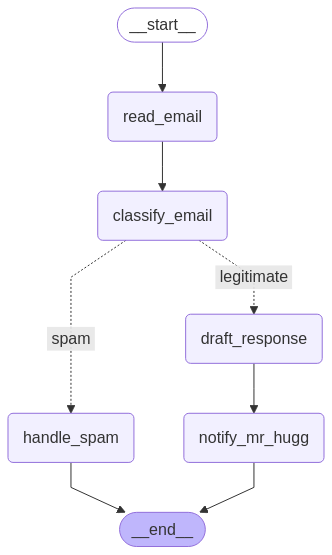

In [8]:
# View
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

### Run the application

In [9]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about Our Services

Dear Mr. Smith,

Thank you for reaching out and for your interest in our consulting services. We would be delighted to discuss how we can assist you. Please let us know your availability for a call next week, and we will do our best to accommodate.

Looking forward to our conversation.

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]


Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.


### References:

> https://huggingface.co/learn/agents-course/  
> https://huggingface.co/learn/agents-course/unit2/langgraph/first_graph
